# 1R1C Thermal Model Example
This notebook demonstrates how to use a simple Resistance-Capacitance (RC) thermal model to simulate indoor temperatures and HVAC loads for multiple buildings.

## Imports
Import required libraries and set visualization defaults.

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from entise.constants import Columns as Cols
from entise.core.generator import TimeSeriesGenerator as TSGen
%matplotlib inline

## Load Data
We load building parameters from `objects.csv` and simulation data from the `data` folder.

In [8]:
cwd = '.'  # Current working directory: change if your kernel is not running in the same folder
objects = pd.read_csv(os.path.join(cwd, 'objects.csv'))
data = {}
common_data_folder = "../common_data"
for file in os.listdir(os.path.join(cwd, common_data_folder)):
    if file.endswith(".csv"):
        name = file.split(".")[0]
        data[name] = pd.read_csv(os.path.join(os.path.join(cwd, common_data_folder, file)), parse_dates=True)
data_folder = 'data'
for file in os.listdir(os.path.join(cwd, data_folder)):
    if file.endswith('.csv'):
        name = file.split('.')[0]
        data[name] = pd.read_csv(os.path.join(os.path.join(cwd, data_folder, file)), parse_dates=True)
print('Loaded data keys:', list(data.keys()))

Loaded data keys: ['weather', 'internal_gains', 'ventilation', 'windows']


## Instantiate and Configure Model
Initialize the time series generator and configure it with building objects.

In [9]:
gen = TSGen()
gen.add_objects(objects)

## Run the Simulation
Generate sequential HVAC load and indoor temperature time series for each building.

In [10]:
summary, df = gen.generate(data, workers=1)

100%|██████████| 9/9 [00:04<00:00,  1.85it/s]


## Results Summary
Below is a summary of the annual heating and cooling demands (in kWh/a) and peak loads (kW).

In [11]:
print("Summary:")
summary_kwh = (summary / 1000).round(0).astype(int)
summary_kwh.rename(columns=lambda x: x.replace("[W]", "[kW]").replace("[Wh]", "[kWh]"), inplace=True)
print(summary_kwh.to_string())

Summary:
          demand_heating[kWh]  load_max_heating[kW]  demand_cooling[kWh]  load_max_cooling[kW]
367791                 279630                   113                90335                   129
31991680               451645                   170                20046                   103
31991682                23989                    10                 8615                    12
31991685               144780                    61                15980                    46
31991686                34961                    14                 6268                    12
31991687                61066                    22                 4169                    14
31991688                81598                    37                 3688                    23
31991690                35605                    17                 4568                    16
31991691                30866                    11                  563                     6


## Visualization of Results
Visualize indoor temperature, heating, and cooling loads for a selected building.

In [12]:
# Select building ID to visualize
building_id = 31991690
building_data = df[building_id]['hvac']

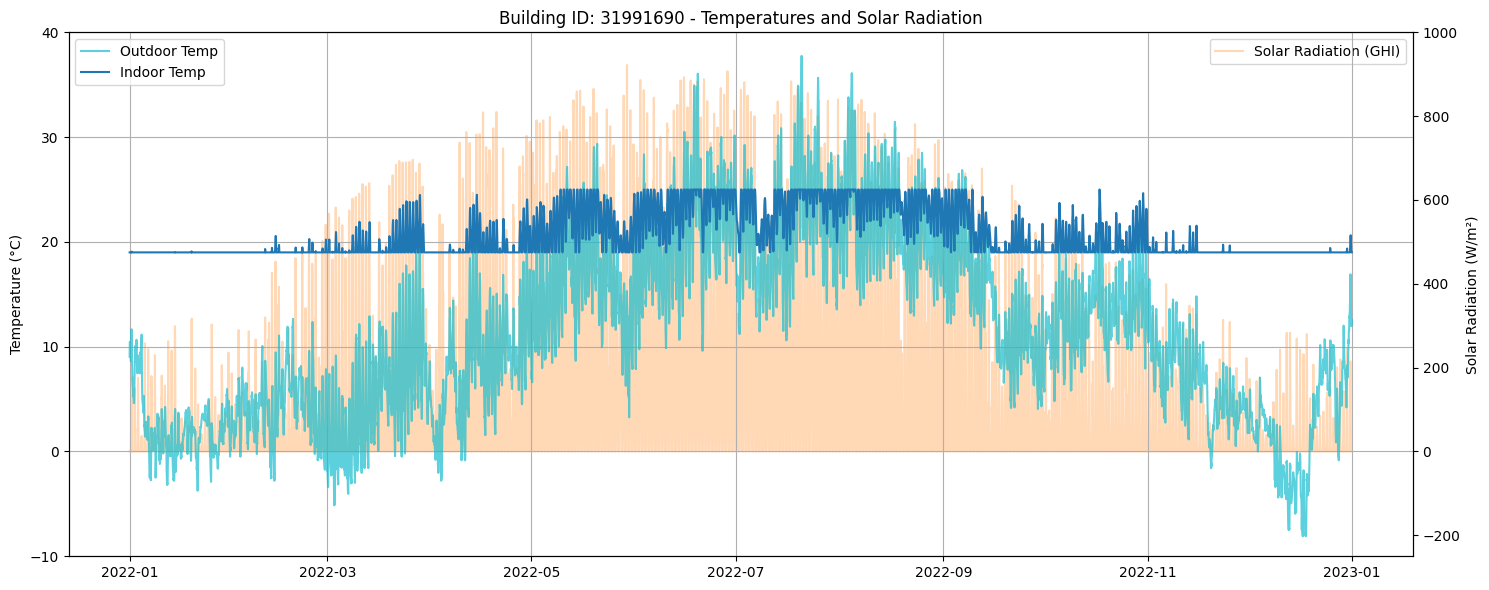

In [13]:
# Figure 1: Indoor & Outdoor Temperature and Solar Radiation (GHI)
fig, ax1 = plt.subplots(figsize=(15, 6))

# Solar radiation plot (GHI) with separate y-axis
ax2 = ax1.twinx()
ax2.plot(
    building_data.index, data["weather"][Cols.SOLAR_GHI],
    label="Solar Radiation (GHI)", color="tab:orange", alpha=0.3
)
ax2.set_ylabel("Solar Radiation (W/m²)")
ax2.legend(loc="upper right")
ax2.set_ylim(-250, 1000)

# Temperature plot
ax1.plot(building_data.index, data["weather"][f"{Cols.TEMP_AIR}@2m"], label="Outdoor Temp", color="tab:cyan", alpha=0.7)
ax1.plot(building_data.index, building_data[Cols.TEMP_IN], label="Indoor Temp", color="tab:blue")
ax1.set_ylabel("Temperature (°C)")
ax1.set_title(f"Building ID: {building_id} - Temperatures and Solar Radiation")
ax1.legend(loc="upper left")
ax1.grid(True)
ax1.set_ylim(-10, 40)

ax1.set_zorder(ax2.get_zorder() + 1)
ax1.patch.set_visible(False)  # required to see through ax1 to ax2
plt.tight_layout()
plt.show()

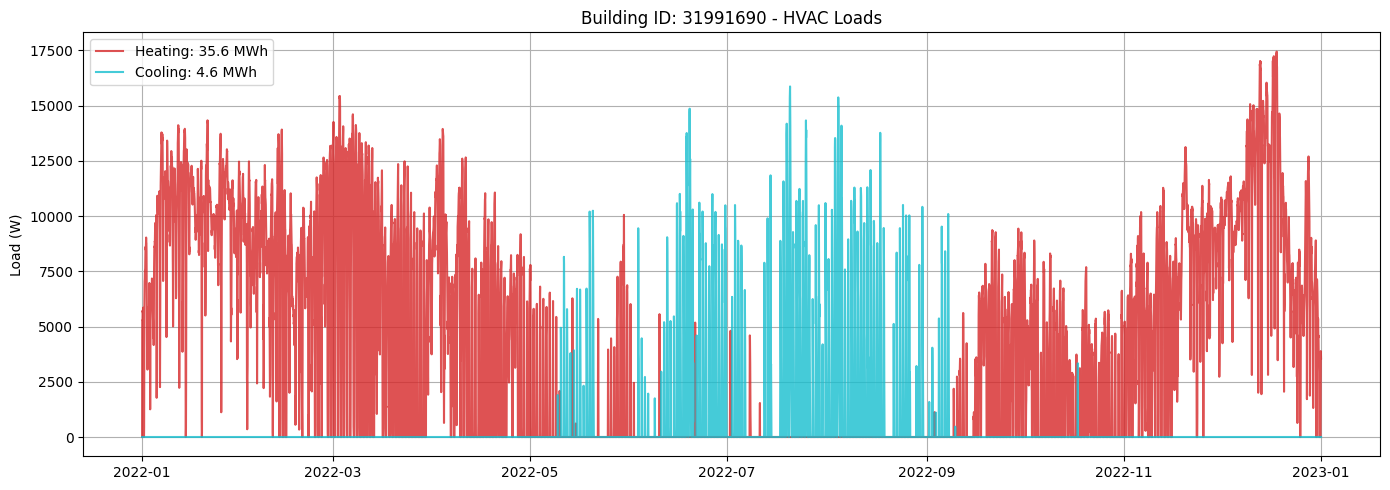

In [14]:
# Figure 2: Heating and Cooling Loads
fig, ax = plt.subplots(figsize=(14, 5))
heating_MWh = summary.loc[building_id, "demand_heating[Wh]"] / 1e6
cooling_MWh = summary.loc[building_id, "demand_cooling[Wh]"] / 1e6
(line1,) = ax.plot(
    building_data.index,
    building_data["load_heating[W]"],
    label=f"Heating: {heating_MWh:.1f} MWh",
    color="tab:red",
    alpha=0.8,
)
(line2,) = ax.plot(
    building_data.index,
    building_data["load_cooling[W]"],
    label=f"Cooling: {cooling_MWh:.1f} MWh",
    color="tab:cyan",
    alpha=0.8,
)
# Create the combined legend in the upper left corner
ax.set_ylabel("Load (W)")
ax.set_title(f"Building ID: {building_id} - HVAC Loads")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

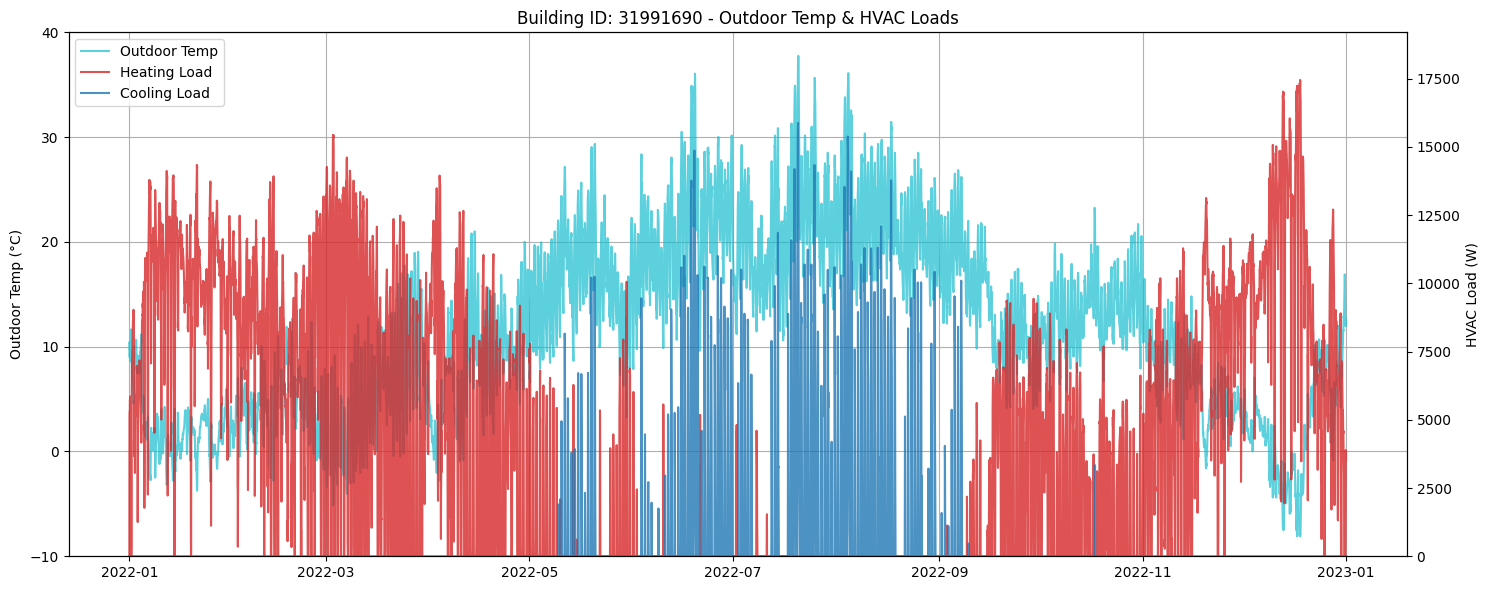

In [15]:
# Figure 3: Outdoor Temperature with Heating & Cooling Loads
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot outdoor temperature on left y-axis
air_temp = data["weather"][f"{Cols.TEMP_AIR}@2m"]
ax1.plot(building_data.index, air_temp
         , label="Outdoor Temp", color="tab:cyan", alpha=0.7)

ax1.set_ylabel("Outdoor Temp (°C)")
ax1.set_ylim(air_temp.min().round() - 2, air_temp.max().round() + 2)

# Create second y-axis for loads
ax2 = ax1.twinx()
ax2.plot(building_data.index, building_data["load_heating[W]"], label="Heating Load", color="tab:red", alpha=0.8)
ax2.plot(building_data.index, building_data["load_cooling[W]"], label="Cooling Load", color="tab:blue", alpha=0.8)
ax2.set_ylabel("HVAC Load (W)")
ax2.set_ylim(
    min(building_data["load_heating[W]"].min(), building_data["load_cooling[W]"].min()) * 1.1,
    max(building_data["load_heating[W]"].max(), building_data["load_cooling[W]"].max()) * 1.1,
)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

ax1.set_title(f"Building ID: {building_id} - Outdoor Temp & HVAC Loads")
ax1.grid(True)
fig.tight_layout()
plt.show()

## Next Steps
You can further explore:
- Adjusting building parameters in `objects.csv`
- Incorporating or excluding additional data (e.g., internal gains, solar gains)
- Investigate how different ventilation strategies impact a buildings energy demand (ventilation)
- Automating analysis for larger building datasets